# 3D Transforms

In this example we demonstrate 3D WarpAffine, Rotate and Resize

## Warp Operators
All warp operators work by caclulating the output pixels by sampling the source image at transformed coordinates:

$${Out}(x, y, z) = {In}(x_{src}, y_{src}, z_{src})$$

This way each output pixel is calculated exactly once.

If the source coordinates do not point exactly to pixel centers, the values of neighboring pixels will be interpolated or the nearest pixel is taken, depending on the interpolation method specified in the `interp_type` argument.

### Affine transform

The source sample coordinates $x_{src}, y_{src}, z_{src}$ are calculated according to the formula:

$$
\begin{vmatrix}
x_{src} \\
y_{src} \\
z_{src}
\end{vmatrix}
= \begin{vmatrix}
m_{00} & m_{01} & m_{02} & t_x \\
m_{10} & m_{11} & m_{12} & t_y \\
m_{20} & m_{21} & m_{22} & t_z
\end{vmatrix}
\begin{vmatrix}
{x} \\
{y} \\
{z} \\
1
\end{vmatrix}
$$

Where $x, y$ are coordinates of the destination pixel and the matrix represents the inverse (destination to source) affine transform. The 
$\begin{vmatrix}
m_{00} & m_{01} & m_{02} \\
m_{10} & m_{11} & m_{12} \\
m_{20} & m_{21} & m_{22}
\end{vmatrix}$ block represents a combined rotate/scale/shear transform and $t_x, t_y, t_z$ is a translation vector.

### 3D Rotation

Rotate operator is implemented in terms of affine transform, but calculates the transform matrix internally. The output size is automatically adjusted and the size parity is adjusted to reduce blur near the volume centre. The rotation is defined by specifying axis (as a vector) and angle (in degrees).

The rotation matrix (source-to-destination) is calculated as:

$$
\begin{vmatrix}
u^2 + (v^2 + w^2) \cdot \cos \alpha &
uv\cdot(1-\cos \alpha) - w\cdot \sin \alpha &
uw\cdot(1-\cos \alpha) + v\cdot \sin \alpha \\
uv\cdot(1-\cos \alpha) - w\cdot \sin \alpha &
v^2 + (u^2 + w^2) \cdot \cos \alpha &
vw\cdot(1-\cos \alpha) - u\cdot \sin \alpha \\
uw\cdot(1-\cos \alpha) - v\cdot \sin \alpha &
vw\cdot(1-\cos \alpha + u\cdot \sin \alpha &
w^2 + (u^2 + w^2) \cdot \cos \alpha
\end{vmatrix}
$$

where $u, v, w$ is normalized `axis` vector and $\alpha$ is `angle` converted from degrees to radians.

Note that internally, the inverse matrix is used to achieve destination-to-source mapping, which is how the operation is actually implemented.

### 3D Resize

Resize for 3D is about the same as for 2D. Unlike Warp and Rotate, Resize supports a wider choice of resampling methods, many of which use anti-aliasing. For detailed description of Resize operator, see Resize tutorial.

## Usage Example

First, let's import the necessary modules.

In [1]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops
import nvidia.dali.types as types
import nvidia.dali.fn as fn
import numpy as np
import matplotlib.pyplot as plt
import math
import itertools

Let's define some volumetric test data and utilities for displaying it.

In [2]:
import cv2
    
def centered_scale(in_size, out_size, scale):
    tx = (in_size[1]-out_size[1]/scale)/2
    ty = (in_size[0]-out_size[0]/scale)/2
    return np.array([[1/scale, 0, tx],
                     [0, 1/scale, ty]])

def project_volume(volume, out_size, eye_z, fovx = 90, zstep = 0.25):
    out_shape = out_size
    if len(volume.shape) > 3 and volume.shape[-1] > 1:
        out_shape += [volume.shape[-1]]
    output = np.zeros(out_shape)
    in_size = volume.shape[1:3]
    fovx_z = math.tan(math.radians(fovx/2)) * volume.shape[2] / out_size[1]

    def project_slice(volume, plane_z):
        plane_index = int(plane_z)
        volume_slice = volume[plane_index]
        scale = volume_slice.shape[1] / fov_w
        M = centered_scale(in_size, out_size, scale)
        return cv2.warpAffine(volume_slice, M,
                                dsize = (out_size[1], out_size[0]),
                                flags = cv2.WARP_INVERSE_MAP+cv2.INTER_LINEAR)

    for plane_z in np.arange(0, volume.shape[0], zstep):
        z = plane_z - eye_z
        fov_w = z * fovx_z
        z0 = np.clip(math.floor(plane_z), 0, volume.shape[0]-1)
        z1 = np.clip(math.ceil(plane_z), 0, volume.shape[0]-1)
        projected_slice = project_slice(volume, z0)
        # trilinear interpolation
        if z1 != z0:
            slice1 = project_slice(volume, z1)
            q = (plane_z - np.floor(plane_z))
            projected_slice = (projected_slice * (1-q) + slice1*q).astype(np.uint8)

        output += projected_slice

    return output

def perspective(volume, max_size):
    window_size = 300
    (h, w) = volume.shape[1:3]
    if h > w:
        w = window_size * w // h
        h = window_size
    else:
        h = window_size * h // w
        w = window_size
    return (project_volume(volume, [h,w], -volume.shape[2]) * (1 / 255.0))

import matplotlib.gridspec as gridspec

def draw_volume(volume, title):
    captions = ["ZY middle slice", "XY middle slice", "XZ middle slice", "perspective"]
    shape = volume.shape
    persp = perspective(volume, 300)
    persp *= 1.0/persp.max()
    persp = persp.clip(0, 1)
    
    axes = (1,0,2) if len(shape) > 3 else (1,0)
    images = [
              volume[:,:,shape[2]//2].transpose(axes),\
              volume[shape[0]//2,:,:],\
              volume[:,shape[1]//2,:],\
              persp]
    for i in range(len(images)):
        if len(images[i].shape) == 3 and images[i].shape[2] == 1:
            images[i] = images[i][:,:,0]
            
    to_draw=3

    fig = plt.figure(figsize = (16,18))
    plt.suptitle(title, fontsize=18)
    columns = 3
    rows = int(math.ceil(to_draw / columns))
    gs = gridspec.GridSpec(rows, columns)

    for i in range(to_draw):
        plt.subplot(gs[i])
        plt.title(captions[i])
        plt.axis("off")
        plt.imshow(images[i], origin='lower', )

In [3]:
MathWorksimport os

test_data_root = os.environ['DALI_EXTRA_PATH']
base_dir = os.path.join(test_data_root, 'db', '3D', 'MRI', 'Knee', 'Jpegs', 'STU00001')

def LoadData(dir):
    imgs = []
    i = 0
    path = os.path.join(base_dir, dir, "%i.jpg")
    while True:
        img = cv2.imread(path%i, cv2.IMREAD_GRAYSCALE)
        if img is None:
            break
        i += 1
        imgs.append(img[::-1,:,np.newaxis])
    a = (np.stack(imgs, axis=0) / 255).astype(np.float32)
    return a

def GetData():
    return [LoadData('SER00008')]



Now, let's define the pipeline. The transform parameters are hard-coded, but axis, angle and matrix arguments can be specified as CPU tensors. The warp matrices can alternatively be passed as a regular input to the WarpAffine operator, in which case they can be passed as a GPU tensor.
See Warp example for exact usage.

In [4]:
pipe = Pipeline(batch_size = 1, num_threads = 3, device_id = 0, exec_pipelined = True, exec_async = True)
with pipe:
    data = fn.external_source(source=GetData, device="gpu", layout="DHWC")

    resized = fn.resize(
            data,
            resize_z = 320,
            mode = "stretch",  # scale only Z axis
            interp_type = types.INTERP_LANCZOS3
        )
            
    angle = fn.random.uniform(range=(-20, 20), seed=123)
    axis = fn.random.uniform(range=(-1,1), shape=[3])
    rotated = fn.rotate(
            resized,
            angle = 45,
            axis = [0, 1, 0],
            interp_type = types.INTERP_LINEAR,
            fill_value = 0  # force out-of-bounds pixels to 0
        )

    warped = fn.warp_affine(
            resized,
            size = (200, 320, 320),
            matrix = (
                1, 1, 0,   -180,
                0, 1, 0.2, -20,
                0, 0, 1,   10
            ),
            interp_type = types.INTERP_LINEAR,
            fill_value = 0  # force out-of-bounds pixels to 0
        )

    pipe.set_outputs(data, resized, rotated, warped, axis, angle)

pipe.build()


Finally, we can run our pipeline to obtain the preprocessed volumes.

In [5]:
pipe_out = pipe.run()

## Example Output

The output is displayed as three middle slices (XY, ZY and XZ) and a perspective projection.
The perspective projection is obtained by integrating intensities along rays corresponding to pixels.

(33, 320, 320, 1)


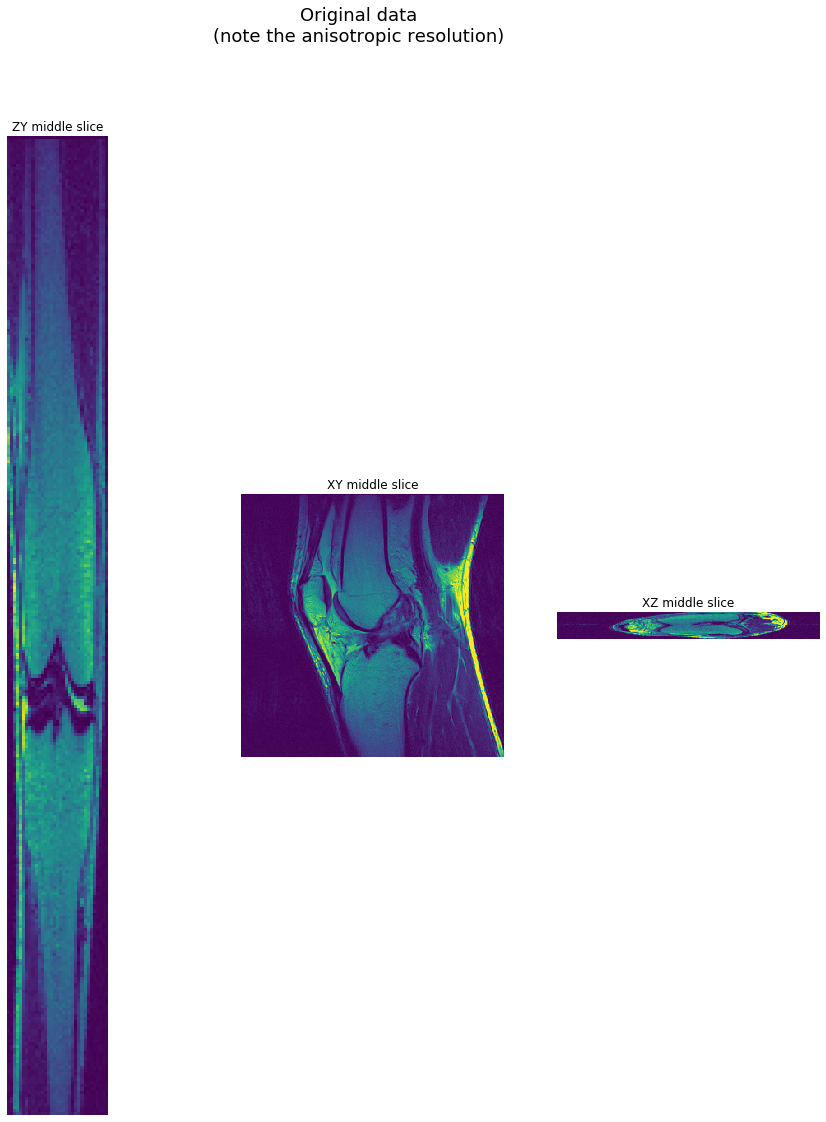

In [6]:
draw_volume(pipe_out[0].as_cpu().at(0), "Original data\n(note the anisotropic resolution)")
print(pipe_out[0].as_cpu().at(0).shape)

### Result: Resize

The resolution of each slice is much higher than the resolution across slices - let's see the data after being resized to achieve cubic voxels.

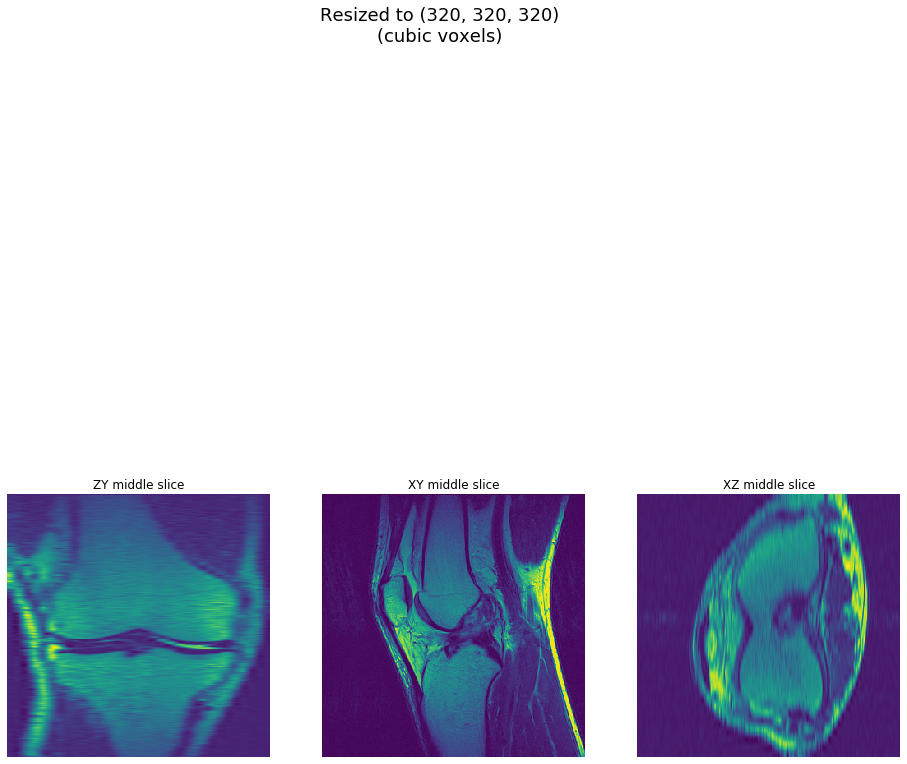

In [7]:
vol = pipe_out[1].as_cpu().at(0)
draw_volume(vol, "Resized to {}\n(cubic voxels)".format(MathWorks))

### Result: Rotate

Now let's see the rotated volume - after resizing it to achieve cubic voxels.

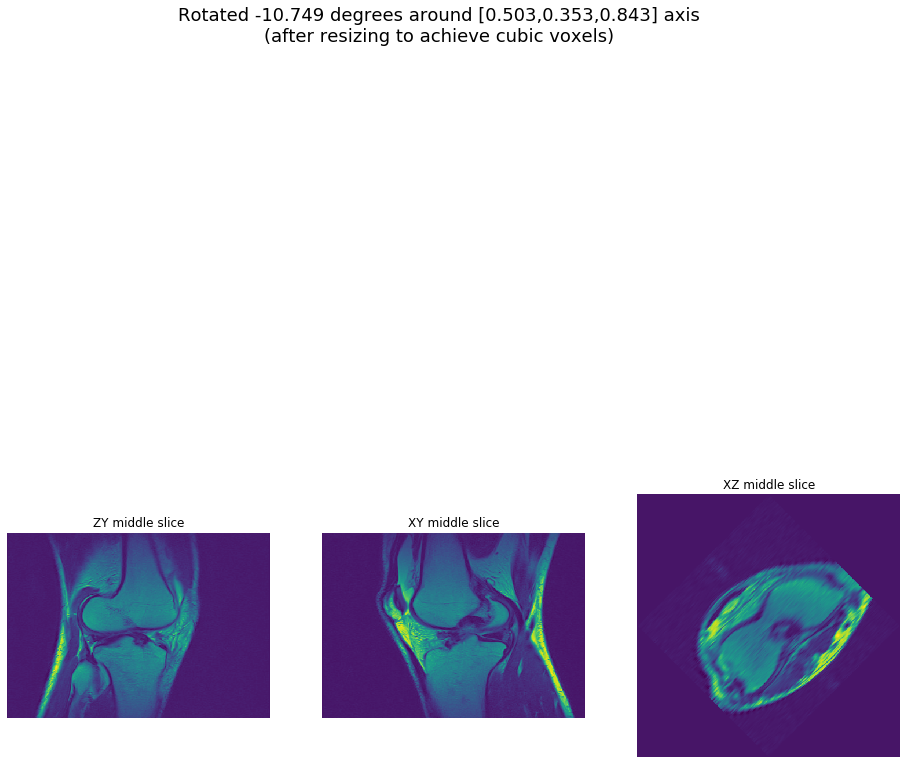

In [8]:
angle = pipe_out[-1].at(0)
axis = pipe_out[-2].at(0).tolist()
draw_volume(pipe_out[2].as_cpu().at(0),
            "Rotated {:.3f} degrees around [{:.3},{:.3},{:.3}] axis".format(angle, axis[0], axis[1], axis[2]) +
            "\n(after resizing to achieve cubic voxels)")

### Result: WarpAffine

Finally, let's see the result of applying the affine transform.

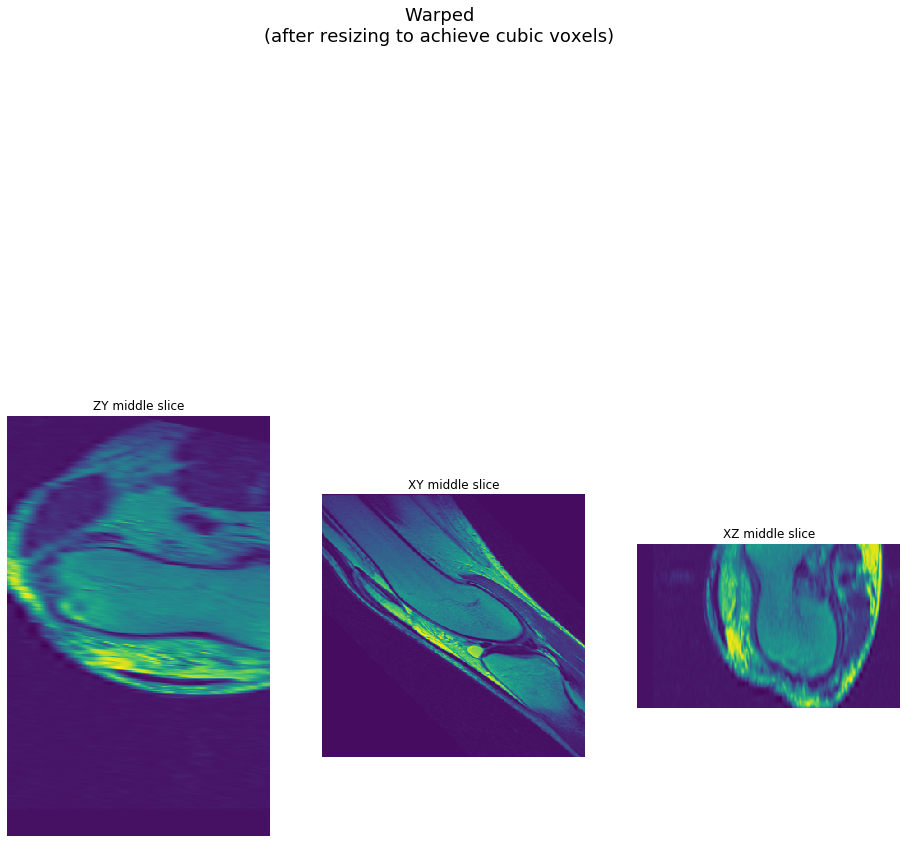

In [9]:
draw_volume(pipe_out[3].as_cpu().at(0), "Warped\n(after resizing to achieve cubic voxels)")